# Assembling the imperfect waterbomb elements

Prototyping notebook -- that was used to formulate the processing of the 
assembly algorithm and misfit analysis step by step. The methods were then 
included in the class WBAssembler 

In [27]:
import k3d
import sympy as sp
sp.init_printing()
import numpy as np
import matplotlib.pylab as plt
from bmcs_shell.folding.assembly.wb_scanned_cell import WBScannedCell, cache_solve

# Modules 3

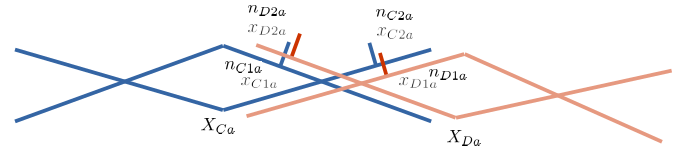

There are two cells positioned in a 2D Euclidian space indexed $C$ and $D$.
In the following, an index $a$ denotes the spatial coordinate index in 2D with the values 0 and 1. Both cells $C$ and $D$ have two reference points provided in the local coordinate system of the cells as $x_{C0a}$, $x_{C1a}$ and $x_{D0a}$, $x_{D1a}$, respectively. Each reference point is associated with a vector defined in the local coordinates of the cells, i.e., $n_{C0a}$, $n_{C1a}$ and $n_{D0a}$, $n_{D1a}$. Each cell is embedded in the global 2D coordinate system via the position of the origin of the local coordinate system of the cell $X_{Ca}$ and $X_{Da}$ and the rotations of the local coordinate systems $\alpha_C$ and $\alpha_D$.

The position of the reference points in local coordinate systems of the respective shells and the associated vectors are known as input parameters. Also the global position $X_{Ca}$ and the rotation angle $\alpha_C$ are input parameters. The global position $X_{Da}$ and the rotation $\alpha_D$ are unknown. The task is to identify these three unknown based on the following three criteria:

 - First criterion: The angle between vectors $n_{C1a}$ and $n_{D2a}$ transformed to the global coordinated system using the respective angles $\alpha_C$ and $\alpha_D$ must be zero. This condition might be formulated as 
 $ \| T_{Cab}(\alpha_C) n_{C2a}$ $T_{Dcd}(\alpha_D) n_{D1c} \epsilon_{ebd} \| = 0$, where $T_{Cab}$ is the rotation matrix depending on the angle $\alpha_C$, $T_{Dcd}$ is the rotation matrix depending on the angle $\alpha_D$, and $\epsilon_{ebd}$ represents the cross-product operator, sometimes referred to as Levi-Civita. But a simpler criterion using dot product and quantified angles is also possible.  

 - Second criterion: Introducing the vector $v_{D1a} = (X_{Ca} + T_{Cab}(\alpha_C) x_{C2a} ) - (X_{Da} + T_{Dab}(\alpha_D) x_{D1a})$ in the global coordinate system, the second criterion says that its projected length on the associated vector must be equal to a specified distance $d$, i.e. $\| v_{D1b} T_{Dab}(\alpha) n_{D1b} \| = d$. 

 - Third criterion: The third criterion is similar to the second criterion, but it takes into account the cell $C$. Given the vector $v_{C1a} = (X_{Da} + T_{Dab}(\alpha_D) x_{D2a} ) - (X_{Ca} + T_{Cab}(\alpha_C) x_{C1a})$, we require that the projected length of the associated vector is equal to the specified parameter $d$, i.e. $\| v_{C1b} T_{Cab}(\alpha_C) n_{Ca} \| = d$.

The task is to resolve these criteria to deliver the closed-form solution for $X_{D0}$, $X_{D1}$, and $\alpha_{D}$.
  


The three necessary conditions are stated as 
 - angle between $n_{C1a}$ and $n_{D2a}$ must be zero,
 - the size of the vector $X_{D2a} - X_{C1a}$ projected to $n_{C2a}$ must be equal to $d$
 - the size of the vector $X_{C2a} - X_{D1a}$ projected to $n_{C2a}$ must be equal to $d$
 

This means
 -  $ \| T_{Cab}(\alpha_C) n_{C2a}$ $T_{Dcd}(\alpha_D) n_{D1c} \epsilon_{ebd} \| = 0$
 - $v_{D1a} = (X_{Ca} + T_{Cab}(\alpha_C) x_{C2a} ) - (X_{Da} + T_{Dab}(\alpha_D) x_{D1a})$, and $\| v_{D1b} T_{Dab} n_{Da} \| = d$
 - $v_{C1a} = (X_{Da} + T_{Dab}(\alpha_D) x_{D2a} ) - (X_{Ca} + T_{Cab}(\alpha_C) x_{C1a})$, and $\| v_{C1b} T_{Cab} n_{Ca} \| = d$

   

A simpler expression is
Define the line vectors based on the normals as
$$
v_{Cfa} = [n_{Cf1}, -n_{Cf0}]
$$
$$
 T_{Ca} + s_C v_{C2a}
$$

## Derive the translation and rotation of a neighbor cell 

Introduce the variables

In [28]:
from sympy import symbols, Matrix, cos, sin, solve, Eq

# Define symbols
alpha_C, d_alpha_D = symbols('alpha_C d_alpha_D')
alpha_D = alpha_C + d_alpha_D

X_C = Matrix(symbols('X_C1, X_C2'))
X_D = Matrix(symbols('X_D1, X_D2'))
x_Cb = Matrix(symbols('x_Cb1, x_Cb2'))
x_Ct = Matrix(symbols('x_Ct1, x_Ct2'))
x_Db = Matrix(symbols('x_Db1, x_Db2'))
x_Dt = Matrix(symbols('x_Dt1, x_Dt2'))
n_Cb = Matrix(symbols('n_Cb1, n_Cb2'))
n_Ct = Matrix(symbols('n_Ct1, n_Ct2'))
n_Db = Matrix(symbols('n_Db1, n_Db2'))
n_Dt = Matrix(symbols('n_Dt1, n_Dt2'))

sp_vars = (alpha_C, X_C, x_Cb, x_Ct, x_Db, x_Dt, n_Cb, n_Ct, n_Db, n_Dt)

X_C1, X_C2 = X_C
X_D1, X_D2 = X_D
X_C1, X_C2, X_D1, X_D2

Symbols needed to determine the position in $x$ direction

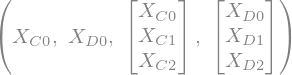

In [29]:
X_C0 = symbols('X_C0')
X_D0 = symbols('X_D0')
X3_C = Matrix([X_C0, X_C1, X_C2])
X3_D = Matrix([X_D0, X_D1, X_D2])
X_C0, X_D0, X3_C, X3_D

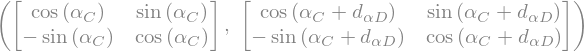

In [30]:
# Rotation matrices
T_C = Matrix([[cos(alpha_C), -sin(alpha_C)], [sin(alpha_C), cos(alpha_C)]]).T
T_D = Matrix([[cos(alpha_D), -sin(alpha_D)], [sin(alpha_D), cos(alpha_D)]]).T

T_C, T_D    


### Criterion 1:

Rotation between the neighbor cells
Calculate the angle between the normal vectors on the planes that interlock. This means the opposite planes

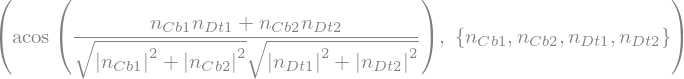

In [31]:
n_Cb_unit = n_Cb / n_Cb.norm()
n_Dt_unit = n_Dt / n_Dt.norm()

# Calculate dot product of n_Cb_global and n_Db_global
dot_product = n_Cb_unit.dot(n_Dt_unit)

# Check if dot product is equal to product of magnitudes    
d_alpha_D_solved = sp.simplify(sp.acos(dot_product))
d_alpha_D_solved, d_alpha_D_solved.free_symbols

### Criterion 2: 

The point X_D1 must be on the line running through X_C2 orthogonal to n_Ct

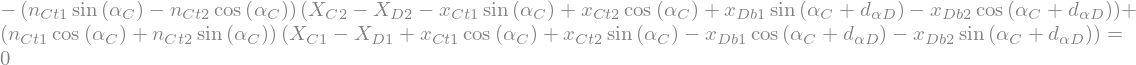

In [32]:
X_Ct = X_C + T_C * x_Ct
X_Db = X_D + T_D * x_Db

# Calculate the vector from the top facet of C to the bottom facet of D
V_C2 = X_Ct - X_Db 

# Rotated normal vector of the top facet of C
N_C2 = T_C * n_Ct

# Calculate misft at the top relative to C 
misfit_Ct = sp.simplify(V_C2.dot(N_C2)) 
criterion2 = sp.Eq( misfit_Ct, 0)
criterion2

### Criterion 3: 

The point X_Dt must be on the line given by the point X_Cb and 
a line perpendicular to N_Cb

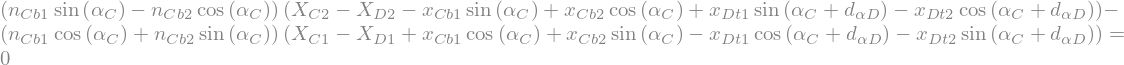

In [33]:
X_Cb = X_C + T_C * x_Cb
X_Dt = X_D + T_D * x_Dt
V_C1 = X_Dt - X_Cb
N_C1 = T_C * n_Cb
misfit_Cb = sp.simplify(V_C1.dot(N_C1))
criterion3 = sp.Eq(misfit_Cb, 0)
criterion3.simplify()


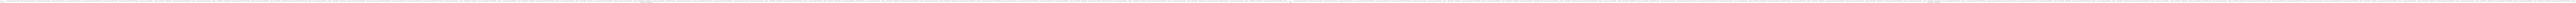

In [34]:
# Solve the system of equations
X_D_solved = cache_solve((criterion2, criterion3), [X_D1, X_D2], "X_D_solved") # , recalculate=True, simplify=True)
X_D_solved

In [35]:
# get_d_alpha_D = sp.lambdify(sp_vars, d_alpha_D_solved)
get_d_alpha_D = sp.lambdify((alpha_C, X_C, n_Cb, n_Dt), d_alpha_D_solved)
get_X_D1 = sp.lambdify(sp_vars + (d_alpha_D,), X_D_solved[X_D1])
get_X_D2 = sp.lambdify(sp_vars + (d_alpha_D,), X_D_solved[X_D2])
get_misfit_Ct = sp.lambdify(sp_vars + (d_alpha_D, X_D), misfit_Ct)
get_misfit_Cb = sp.lambdify(sp_vars + (d_alpha_D, X_D), misfit_Cb)


## Facets points from 3D scan

In [36]:
colors = [0xff0000, 0x00ff00, 0x0000ff, 0xffff00, 0xff00ff, 0x00ffff,
          0xff0099, 0xff9900, 0x99ff00, 0x00ff99, 0x9900ff, 0x0099ff,
          0xff9999, 0x99ff99, 0x9999ff, 0xffff99, 0xff99ff, 0x99ffff]

### Define the corner map

Define an index array with the shape (2,2,2) where first two dimensions denote corners  and the last dimension stands for bottom and top facet  

In [37]:
corner_map = np.array([[[17, 10],[15, 3], ], [[16, 10],[14, 3]]], dtype=np.int_)
diag_corner_map = np.array([[(0, 0), (0, 1)], [(1, 0), (1, 1)]])

def get_corner_f(diag_dir, y_dir):
    diag_index = 0 if diag_dir == -1 else 1
    y_index = 0 if y_dir == -1 else 1
    return corner_map[tuple(diag_corner_map[diag_index][y_index])]

In [38]:
x_dir_ = np.array([[1, -1],[-1, 1]])
def get_x_dir( diag_dir, y_dir):
    return diag_dir * y_dir
get_x_dir(-1, -1)

In [39]:
# def plug_D_into_C(wb_plugged, wb_fixed, diag_dir, y_dir, d_X_0=565):
def plug_D_into_C(wb_plugged, wb_fixed, diag_dir, y_dir, d_X_0=569.5):
    """569.5
    Plug wb_D into wb_C along the selected diagonal.
    """
    side_fixed, side_plugged = np.array([1, -1]) * y_dir
    x_Cfa = wb_fixed.O_centroids_Fa[get_corner_f(diag_dir,side_fixed),1:]
    n_Cfa = wb_fixed.O_normals_Fa[get_corner_f(diag_dir,side_fixed),1:]
    x_Dfa = wb_plugged.O_centroids_Fa[get_corner_f(diag_dir,side_plugged),1:]
    n_Dfa = wb_plugged.O_normals_Fa[get_corner_f(diag_dir,side_plugged),1:]

    alpha_C_ = wb_fixed.alpha
    X_C_ = wb_fixed.X_a[1:]
    
    # compute alpha_d
    d_alpha_D_n_ = y_dir * get_d_alpha_D(alpha_C_, X_C_, n_Cfa[0], n_Dfa[1])
    
    # compute X_D1 and X_D2 from the 2nd and 3rd criterion
    X_D1_ = get_X_D1(alpha_C_, X_C_, x_Cfa[0], x_Cfa[1], x_Dfa[0], x_Dfa[1], n_Cfa[0], n_Cfa[1], n_Dfa[0], n_Dfa[1], d_alpha_D_n_)
    X_D2_ = get_X_D2(alpha_C_, X_C_, x_Cfa[0], x_Cfa[1], x_Dfa[0], x_Dfa[1], n_Cfa[0], n_Cfa[1], n_Dfa[0], n_Dfa[1], d_alpha_D_n_)

    X_D0_ = wb_fixed.X_a[0] + d_X_0 * get_x_dir(diag_dir, y_dir)
    wb_plugged.alpha = alpha_C_ + d_alpha_D_n_
    wb_plugged.X_a = [X_D0_, X_D1_, X_D2_]

In [40]:
def get_misfit(wb_D, wb_C, diag_dir, y_dir=1):
    """
    Plug wb_D into wb_C along the diagonal diag.
    """
    side_fixed, side_plugged = np.array([1, -1]) * y_dir
    x_Cfa = wb_C.O_centroids_Fa[get_corner_f(diag_dir,side_fixed),1:]
    n_Cfa = wb_C.O_normals_Fa[get_corner_f(diag_dir,side_fixed),1:]
    x_Dfa = wb_D.O_centroids_Fa[get_corner_f(diag_dir,side_plugged),1:]
    n_Dfa = wb_D.O_normals_Fa[get_corner_f(diag_dir,side_plugged),1:]

    alpha_C_ = wb_C.alpha
    d_alpha_D_ = wb_D.alpha - alpha_C_
    X_C_ = wb_C.X_a[1:]
    X_D_ = wb_D.X_a[1:]

    misfit_Cb = get_misfit_Cb(alpha_C_, X_C_, x_Cfa[0], x_Cfa[1], x_Dfa[0], x_Dfa[1], n_Cfa[0], 
                    n_Cfa[1], n_Dfa[0], n_Dfa[1], d_alpha_D_, X_D_)
    misfit_Ct = get_misfit_Ct(alpha_C_, X_C_, x_Cfa[0], x_Cfa[1], x_Dfa[0], x_Dfa[1], n_Cfa[0], 
                    n_Cfa[1], n_Dfa[0], n_Dfa[1], d_alpha_D_, X_D_)

    return misfit_Cb, misfit_Ct


In [41]:
def plot_plugged_neighbors_yz(wb_fixed, wb_plugged, diag_dir, y_dir, ax):

    side_fixed, side_plugged = np.array([1, -1]) * y_dir

    x_Cfa = wb_fixed.O_centroids_Fa[get_corner_f(diag_dir,side_fixed),1:]
    n_Cfa = wb_fixed.O_normals_Fa[get_corner_f(diag_dir,side_fixed),1:]
    x_Dfa = wb_plugged.O_centroids_Fa[get_corner_f(diag_dir,side_plugged),1:]
    n_Dfa = wb_plugged.O_normals_Fa[get_corner_f(diag_dir,side_plugged),1:]

    scale = 50
    x2_Cfa = x_Cfa + n_Cfa * scale
    x2_Dfa = x_Dfa + n_Dfa * scale

    nC_alf = np.einsum('lfa->alf', np.array([x_Cfa, x2_Cfa]))
    nD_alf = np.einsum('lfa->alf', np.array([x_Dfa, x2_Dfa]))

    ax.plot(*x_Cfa.T, 'o', color='blue')
    ax.plot(*x_Dfa.T, 'o', color='green')

    ax.plot(*nC_alf[:,:,0], color='orange')
    ax.plot(*nD_alf[:,:,1], color='orange')

    O_crease_lines_X_aLi = np.einsum('Lia->aiL', wb_fixed.O_crease_lines_X_Lia)
    ax.plot(*O_crease_lines_X_aLi[1:,...], color='blue')
    O_crease_lines_X_aLi = np.einsum('Lia->aiL', wb_plugged.O_crease_lines_X_Lia)
    ax.plot(*O_crease_lines_X_aLi[1:,...], color='green')

    ax.set_aspect('equal')


In [42]:
def get_slit_seq(slit_Si):
    cell_pair_pC = cell_enum[slit_Si[:,:2]] - 1
    from_slit_diag_p = slit_Si[:, 2]
    from_slit_dir_p = slit_Si[:, 3]
    return cell_pair_pC, from_slit_diag_p, from_slit_dir_p


In [43]:
def plug_modules(wbs, plug_pi):
    for wb_link, diag, dir in zip(*get_slit_seq(plug_pi)):
        wb_fixed, wb_plugged = wbs[wb_link]
        plug_D_into_C(wb_plugged, wb_fixed, diag, dir)

def reset_modules(wbs):
    for wb in wbs:
        wb.alpha = 0
        wb.X_a = [0,0,0]
        wb.O_flip = 1

def plot_modules_3D(wbs, plot, module_numbers=True, facet_numbers=False):
    for i, wb in enumerate(wbs):
        color = colors[i % len(colors)]
        wb.plot_points(plot, wb.G_centroids_Fa[[14,15,16,17]], point_size=8, plot_numbers=facet_numbers)
        wb.plot_G_facets(plot, color=color, module_numbers=module_numbers)

def plot_modules_yz(wbs, ax):
    for i, wb in enumerate(wbs):
        G_crease_lines_X_aLi = np.einsum('Lia->aiL', wb.G_crease_lines_X_Lia)
        ax.plot(*G_crease_lines_X_aLi[1:,...], color='black')
    ax.set_aspect('equal')

def plot_modules_xz(wbs, ax):
    for i, wb in enumerate(wbs):
        G_crease_lines_X_aLi = np.einsum('Lia->aiL', wb.G_crease_lines_X_Lia)
        ax.plot(*G_crease_lines_X_aLi[[0,2],...], color='black')
    ax.set_aspect('equal')


### Read the scanned files for individual cells

Demonstrator series

In [44]:
import itertools

modules = {'WB300': ('WB305_facets_points.obj', [[1, 0], [np.pi/2, np.pi/2]]),
           'WB301': ('WB306_facets_points.obj', [[1, 0], [np.pi/2, -np.pi/2]]),
           'WB302': ('WB307_facets_points.obj', [[1], [np.pi/2]]),
           'WB303': ('WB308_facets_points.obj', [[1, 2], [np.pi/2, np.pi]]),
           'WB304': ('WB309_facets_points.obj', [[0, 2], [np.pi/2, -np.pi/2]]),
           'WB305': ('WB310_facets_points.obj', [[1, 2], [np.pi/2, np.pi]]),
           'WB306': ('WB311_facets_points.obj', [[1], [np.pi/2]]),
           'WB307': ('WB312_facets_points.obj', [[1], [-np.pi/2]]),
           'WB308': ('WB305_facets_points.obj', [[1, 0], [np.pi/2, np.pi/2]]),
           'WB309': ('WB306_facets_points.obj', [[1, 0], [np.pi/2, -np.pi/2]]),
           }

permutation = np.array(list(itertools.permutations(modules, 9)))
permutation_05 = permutation[0]


In [45]:
permutation.shape

In [46]:
# Filter and preserve order of tuple
permutation_05 = {k: modules[k] for k in permutation_05}

modules_list = [(k, *v, c) for (k, v), c in zip(permutation_05.items(), colors) ]

def read_modules(modules):
    return np.array([WBScannedCell(file_path=file, label=key,
                                         rotate_system=rotate_system) 
        for key, file, rotate_system, _ in modules_list ], dtype=np.object_)
cell_enum = np.arange(1,len(modules_list)+1)


In [47]:
# first index is the diagonal direction, second index is the y direction
# 0 - diag_dir, 1 - y_dir

plug_pi = np.array([
    [0, 1, 1, 1],
    [0, 2, -1, 1], 
    [0, 3, 1, -1], 
    [0, 4, -1, -1], 
    [1, 5, -1, 1],
    [1, 6, -1, -1],
    [3, 7, -1, 1],
    [3, 8, -1, -1],
], dtype=np.int_)
for idx, (key, (filename, _)) in enumerate(permutation_05.items()):
    print(f"{idx} - {key} - {filename}")

0 - WB300 - WB305_facets_points.obj
1 - WB301 - WB306_facets_points.obj
2 - WB302 - WB307_facets_points.obj
3 - WB303 - WB308_facets_points.obj
4 - WB304 - WB309_facets_points.obj
5 - WB305 - WB310_facets_points.obj
6 - WB306 - WB311_facets_points.obj
7 - WB307 - WB312_facets_points.obj
8 - WB308 - WB305_facets_points.obj


In [48]:
plot = k3d.plot(name='Vectors')
wbs_05 = read_modules(modules_list)
plug_modules(wbs_05, plug_pi[:])
plot_modules_3D(wbs_05, plot, module_numbers=True, facet_numbers=False)
# Display the plot and the legend side by side
plot.display()



/Users/gui/Documents/VSCode/bmcs_env/lib/python3.12/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

In [49]:
def get_module_misfits(wbs, slit_pi):
    misfits_ = []
    for wb_link, diag, dir in zip(*get_slit_seq(slit_pi)):
        wb_fixed, wb_plugged = wbs[wb_link]
        m1 = get_misfit(wb_plugged, wb_fixed, diag, dir)
        misfits_.append(m1)

    misfits = np.array(misfits_)
    return misfits

misfit_pi = np.array([
    [2, 5, 1, 1], 
    [2, 7, 1, -1], 
    [4, 6, 1, 1], 
    [4, 8, 1, -1], 
])
get_module_misfits(wbs_05, misfit_pi)

array([[ 0.8378378 ,  3.81991724],
       [-2.20465011, -1.71640471],
       [ 6.0055419 , -7.84076702],
       [-5.1576403 , -0.16925649]])

# Running all combinations

In [50]:
# Filter and preserve order of tuple
misfit_tC = []

n = 10  # for example, number of random samples you want
#permutation = permutation[:10]

permutation = permutation[np.random.choice(len(permutation), n, replace=False)]

# get random a number n of samples
for permutation_05 in permutation:
    permutation_05 = {k: modules[k] for k in permutation_05}
    modules_list = [(k, *v, c) for (k, v), c in zip(permutation_05.items(), colors) ]
    cell_enum = np.arange(1,len(modules_list)+1)
    wbs_05 = read_modules(modules_list)
    plug_modules(wbs_05, plug_pi[:])
    misfit_C = get_module_misfits(wbs_05, misfit_pi)
    misfit_tC.append(misfit_C)


In [51]:
best_t = np.argmin(np.max(np.fabs(misfit_tC), axis=(1,2)))
misfit_tC[best_t], permutation[best_t], best_t

(array([[ 5.92349692,  0.4834556 ],
        [-1.53721294,  1.68670758],
        [ 6.01824988, -0.63108775],
        [-2.90107478, -0.9766024 ]]),
 array(['WB300', 'WB306', 'WB305', 'WB302', 'WB308', 'WB301', 'WB303',
        'WB309', 'WB304'], dtype='<U5'),
 3)

In [52]:
# Plot best permutation
index = 8108

permutation = {k: modules[k] for k in permutation[best_t]}
modules_list = [(k, *v, c) for (k, v), c in zip(permutation.items(), colors) ]
cell_enum = np.arange(1,len(modules_list)+1)
wbs = read_modules(modules_list)
plug_modules(wbs, plug_pi[:])
misfit_C = get_module_misfits(wbs, misfit_pi)

plot = k3d.plot(name='Vectors')
plot_modules_3D(wbs, plot, module_numbers=True, facet_numbers=False)
# Display the plot and the legend side by side
plot.display()


Output()